<a href="https://colab.research.google.com/github/ibombonato/aicrowd-blitz-faceimages/blob/main/FineTuneFastAI_FaceImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HuggingPics 🤗🖼️

Fine-tune Vision Transformers for **anything** using images found on the web.

In [ ]:
!nvidia-smi

In [ ]:
!pip install --upgrade fastai --quiet

In [3]:
! pip install transformers pytorch-lightning --quiet

     |████████████████████████████████| 3.5 MB 13.1 MB/s 
     |████████████████████████████████| 527 kB 48.5 MB/s 
     |████████████████████████████████| 67 kB 4.5 MB/s 
     |████████████████████████████████| 596 kB 17.7 MB/s 
     |████████████████████████████████| 895 kB 53.0 MB/s 
     |████████████████████████████████| 6.8 MB 55.2 MB/s 
     |████████████████████████████████| 829 kB 35.5 MB/s 
     |████████████████████████████████| 397 kB 15.0 MB/s 
     |████████████████████████████████| 134 kB 50.6 MB/s 
     |████████████████████████████████| 952 kB 39.6 MB/s 
     |████████████████████████████████| 1.1 MB 43.7 MB/s 
     |████████████████████████████████| 144 kB 19.8 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
     |████████████████████████████████| 271 kB 50.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 

## AiCrowd Setup

In [4]:
!pip install aicrowd-cli --quiet

     |████████████████████████████████| 50 kB 4.5 MB/s 
     |████████████████████████████████| 1.1 MB 55.7 MB/s 
     |████████████████████████████████| 214 kB 46.0 MB/s 
     |████████████████████████████████| 170 kB 52.1 MB/s 
     |████████████████████████████████| 54 kB 2.0 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 51 kB 3.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [1]:
%load_ext aicrowd.magic
%aicrowd login

Please login here: https://api.aicrowd.com/auth/-P1-C_dAZt1GCqX1pGfcf4awa40PTCUfziSMgIc4RQ8
API Key valid
Gitlab access token valid
Saved details successfully!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Ai Crowd Dataloader

In [3]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c age-prediction -o data

sample_submission.csv:   0%|          | 0.00/36.0k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/36.0k [00:00<?, ?B/s]

test.zip:   0%|          | 0.00/176M [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/48.3k [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/236M [00:00<?, ?B/s]

val.csv:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

val.zip:   0%|          | 0.00/117M [00:00<?, ?B/s]

In [4]:
!unzip data/train.zip -d data/train > /dev/null
!unzip data/val.zip -d data/val > /dev/null
!unzip data/test.zip -d data/test > /dev/null

In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

In [6]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv("data/sample_submission.csv")

## Adjust Images from folders

Here, we loop over images and split into separated folders by label

In [7]:
from pathlib import Path
import os
import shutil 

def create_dirs(labels, splits):
  for split in splits:
    for label in labels:
      os.makedirs(f"/content/images/{split}/{label}/", exist_ok=True)

def image_to_label_folder(img_name, label_directory, split_directory):
  origin = Path(f"/content/data/{split_directory}/{img_name}.jpg")
  target = Path(f"/content/images/{split_directory}/{label_directory}/{img_name}.jpg")
  shutil.copy(origin, target)

In [8]:
labels = train_df.age.unique()

In [9]:
create_dirs(labels, ["train", "val"])

In [ ]:
#!rm -r /content/lightning_logs

In [10]:
def move_images(df, split):
  df.progress_apply(lambda x: image_to_label_folder(x["ImageID"],x["age"], split), axis=1)

In [11]:
move_images(train_df, "train")
move_images(val_df, "val")

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

## Init Dataset and Split into Training and Validation Sets


In [14]:
import torch

In [15]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [17]:
from fastai.vision.all import *
path = '/content/images'

dls = ImageDataLoaders.from_folder(
    path, train='train', valid='val', item_tfms=Resize(224), 
                                        batch_tfms=aug_transforms(size=224))

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0006918309954926372)

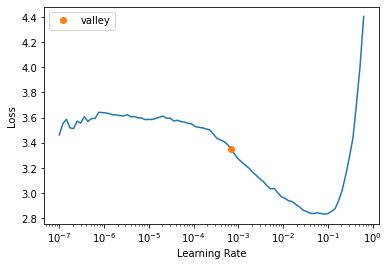

In [18]:
learn = cnn_learner(dls, resnet101, metrics=[error_rate, accuracy]).to_fp16()
learn.lr_find()

In [19]:
learn.fit_one_cycle(10, 0.0006918309954926372)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.757936,1.634558,0.621000,0.379000,01:00
1,2.055358,1.408527,0.521500,0.478500,00:53
2,1.606814,1.190347,0.463500,0.536500,00:52
3,1.251335,1.069704,0.431000,0.569000,00:52
4,1.020089,0.927012,0.400500,0.599500,00:53
5,0.857737,0.922731,0.374500,0.625500,00:53
6,0.752830,0.843790,0.355500,0.644500,00:52
7,0.688545,0.815359,0.339500,0.660500,00:53
8,0.617182,0.816474,0.343000,0.657000,00:53
9,0.589491,0.821157,0.337500,0.662500,00:53


SuggestedLRs(valley=3.630780702224001e-05)

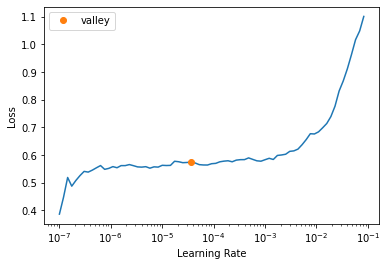

In [20]:
learn.lr_find()

In [21]:
learn.fine_tune(10, 3.630780702224001e-05)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.581816,0.810803,0.339000,0.661000,00:52


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.575619,0.808190,0.337000,0.663000,00:54
1,0.571749,0.804642,0.334000,0.666000,00:54
2,0.557587,0.806608,0.329500,0.670500,00:54
3,0.565605,0.799078,0.328500,0.671500,00:54
4,0.545447,0.796741,0.329000,0.671000,00:54
5,0.532720,0.803946,0.327000,0.673000,00:54
6,0.520948,0.795132,0.331000,0.669000,00:54
7,0.514510,0.813225,0.326000,0.674000,00:54
8,0.517543,0.786209,0.331000,0.669000,00:54
9,0.506730,0.813290,0.326500,0.673500,00:54


SuggestedLRs(valley=1.3182567499825382e-06)

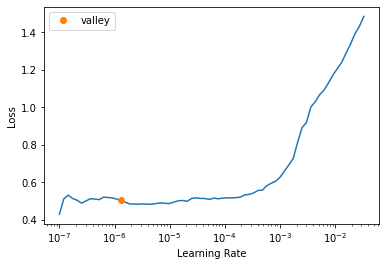

In [22]:
learn.lr_find()

In [28]:
learn.fine_tune(10, 2.0892961401841603e-05)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.494652,0.807920,0.326000,0.674000,00:52


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.509176,0.792574,0.332500,0.667500,00:54
1,0.486550,0.790397,0.322500,0.677500,00:55
2,0.488444,0.799228,0.319500,0.680500,00:55
3,0.494519,0.804974,0.321500,0.678500,00:54
4,0.484616,0.796619,0.324000,0.676000,00:55
5,0.495169,0.790333,0.320000,0.680000,00:55
6,0.482313,0.780272,0.324000,0.676000,00:55
7,0.469491,0.781978,0.327000,0.673000,00:55
8,0.475650,0.787967,0.324500,0.675500,00:55
9,0.484358,0.810088,0.324000,0.676000,00:55


SuggestedLRs(valley=2.0892961401841603e-05)

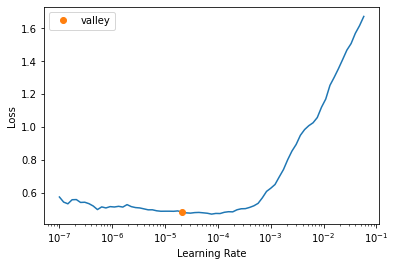

In [27]:
learn.lr_find()

In [29]:
test_df['image'] = test_df['ImageID'].apply(lambda x: f"/content/data/test/{x}.jpg")

test_dl_df = dls.test_dl(test_df['image'])

preds_test_df = learn.get_preds(dl=test_dl_df)
labelled_preds = [learn.dls.vocab[pred.argmax()] for pred in preds_test_df[0]]

In [30]:
for pred in preds_test_df[0]:
  print(tensor(pred))
  break

TensorBase([2.2994e-09, 9.6401e-11, 4.0648e-13, 4.5619e-12, 2.3759e-12, 1.3432e-12,
        4.7808e-12, 3.3066e-09, 1.9638e-06, 1.0000e+00])


In [ ]:
learn.dls.vocab

['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']

In [31]:
test_df['age_pred_resnet101'] = [pred for pred in preds_test_df[0]]

In [32]:
import pathlib
FILES_PATH = "/content/drive/MyDrive/models/vit-age-classifier/"
FILE_NAME = "emsenble_20220222_221749.csv"
file_path = pathlib.Path(FILES_PATH, FILE_NAME)
df_ensemble = pd.read_csv(file_path)
df_ensemble.head()

,ImageID,age,age_pred_vit,age_pred_swin,age_pred_resnet34
0,8rti7,40-50,"tensor([[1.6077e-04, 1.3633e-04, 1.4357e-04, 1.8616e-04, 1.2130e-04, 1.7093e-04,\n 1.6369e-04, 1.1879e-04, 1.9556e-04, 9.9860e-01]])","tensor([[3.7393e-06, 2.5826e-08, 8.5827e-08, 1.1917e-07, 1.2385e-07, 1.3020e-07,\n 4.5356e-08, 3.9004e-08, 6.1547e-08, 1.0000e+00]])","TensorBase([8.8940e-07, 1.2117e-08, 5.3352e-09, 1.3465e-08, 1.2403e-09, 2.2111e-09,\n 1.9361e-09, 4.5110e-08, 1.0111e-04, 9.9990e-01])"
1,575pj,30-40,"tensor([[0.5889, 0.4026, 0.0013, 0.0009, 0.0010, 0.0010, 0.0010, 0.0011, 0.0011,\n 0.0010]])","tensor([[7.8023e-05, 9.9991e-01, 3.6419e-06, 1.2895e-08, 8.1944e-08, 3.0082e-07,\n 2.1684e-07, 1.3851e-06, 4.3010e-06, 7.3960e-07]])","TensorBase([1.4766e-01, 3.9670e-01, 4.4603e-01, 9.3296e-03, 2.7709e-04, 2.8055e-06,\n 4.2856e-07, 3.2155e-08, 7.2180e-08, 8.1008e-07])"
2,6ma92,30-40,"tensor([[9.7703e-01, 2.0050e-02, 4.2907e-04, 3.6434e-04, 3.3977e-04, 3.6260e-04,\n 3.5799e-04, 3.3499e-04, 3.8148e-04, 3.5520e-04]])","tensor([[9.9992e-01, 6.4807e-05, 1.7996e-08, 3.5407e-08, 1.1226e-06, 4.6602e-07,\n 2.4163e-06, 3.2488e-06, 2.2185e-06, 2.0252e-06]])","TensorBase([9.6116e-01, 3.8753e-02, 8.5436e-05, 8.8445e-07, 3.3969e-08, 4.0809e-09,\n 3.9399e-09, 4.6970e-09, 9.0892e-09, 8.7937e-08])"
3,jtu3e,20-30,"tensor([[3.2472e-04, 4.4284e-04, 1.3452e-03, 9.9037e-01, 5.1099e-03, 6.4651e-04,\n 4.0343e-04, 4.7030e-04, 5.3039e-04, 3.6106e-04]])","tensor([[2.6662e-07, 5.0047e-07, 3.6239e-05, 9.9809e-01, 1.8626e-03, 9.4663e-07,\n 2.2572e-07, 5.1989e-06, 3.6227e-06, 4.5946e-06]])","TensorBase([2.9232e-05, 5.7046e-04, 1.4937e-02, 5.0835e-01, 4.1815e-01, 5.5714e-02,\n 2.0433e-03, 1.9724e-04, 5.8353e-06, 1.8148e-06])"
4,svx4s,10-20,"tensor([[1.4139e-03, 1.0321e-03, 2.4524e-03, 2.5184e-02, 9.6247e-01, 3.1046e-03,\n 7.7733e-04, 1.1875e-03, 1.3354e-03, 1.0469e-03]])","tensor([[7.3041e-05, 2.6791e-05, 3.0605e-01, 4.9026e-01, 2.0180e-01, 1.8372e-04,\n 2.0147e-04, 3.6610e-04, 7.6897e-04, 2.6873e-04]])","TensorBase([0.0009, 0.0083, 0.0536, 0.1288, 0.5739, 0.1625, 0.0075, 0.0556, 0.0053,\n 0.0036])"


In [33]:
df_ensemble = pd.merge(df_ensemble, test_df[['ImageID', 'age_pred_resnet101']])
df_ensemble.head()

,ImageID,age,age_pred_vit,age_pred_swin,age_pred_resnet34,age_pred_resnet101
0,8rti7,40-50,"tensor([[1.6077e-04, 1.3633e-04, 1.4357e-04, 1.8616e-04, 1.2130e-04, 1.7093e-04,\n 1.6369e-04, 1.1879e-04, 1.9556e-04, 9.9860e-01]])","tensor([[3.7393e-06, 2.5826e-08, 8.5827e-08, 1.1917e-07, 1.2385e-07, 1.3020e-07,\n 4.5356e-08, 3.9004e-08, 6.1547e-08, 1.0000e+00]])","TensorBase([8.8940e-07, 1.2117e-08, 5.3352e-09, 1.3465e-08, 1.2403e-09, 2.2111e-09,\n 1.9361e-09, 4.5110e-08, 1.0111e-04, 9.9990e-01])","[TensorBase(2.2994e-09), TensorBase(9.6401e-11), TensorBase(4.0648e-13), TensorBase(4.5619e-12), TensorBase(2.3759e-12), TensorBase(1.3432e-12), TensorBase(4.7808e-12), TensorBase(3.3066e-09), TensorBase(1.9638e-06), TensorBase(1.0000)]"
1,575pj,30-40,"tensor([[0.5889, 0.4026, 0.0013, 0.0009, 0.0010, 0.0010, 0.0010, 0.0011, 0.0011,\n 0.0010]])","tensor([[7.8023e-05, 9.9991e-01, 3.6419e-06, 1.2895e-08, 8.1944e-08, 3.0082e-07,\n 2.1684e-07, 1.3851e-06, 4.3010e-06, 7.3960e-07]])","TensorBase([1.4766e-01, 3.9670e-01, 4.4603e-01, 9.3296e-03, 2.7709e-04, 2.8055e-06,\n 4.2856e-07, 3.2155e-08, 7.2180e-08, 8.1008e-07])","[TensorBase(0.9913), TensorBase(0.0081), TensorBase(0.0006), TensorBase(2.2717e-05), TensorBase(2.4464e-06), TensorBase(3.3761e-07), TensorBase(5.5122e-07), TensorBase(1.4836e-07), TensorBase(3.3494e-08), TensorBase(2.7613e-06)]"
2,6ma92,30-40,"tensor([[9.7703e-01, 2.0050e-02, 4.2907e-04, 3.6434e-04, 3.3977e-04, 3.6260e-04,\n 3.5799e-04, 3.3499e-04, 3.8148e-04, 3.5520e-04]])","tensor([[9.9992e-01, 6.4807e-05, 1.7996e-08, 3.5407e-08, 1.1226e-06, 4.6602e-07,\n 2.4163e-06, 3.2488e-06, 2.2185e-06, 2.0252e-06]])","TensorBase([9.6116e-01, 3.8753e-02, 8.5436e-05, 8.8445e-07, 3.3969e-08, 4.0809e-09,\n 3.9399e-09, 4.6970e-09, 9.0892e-09, 8.7937e-08])","[TensorBase(0.6039), TensorBase(0.3960), TensorBase(6.0648e-05), TensorBase(1.4138e-06), TensorBase(1.6724e-06), TensorBase(1.0322e-07), TensorBase(2.5626e-06), TensorBase(2.7226e-06), TensorBase(8.5573e-08), TensorBase(2.3654e-06)]"
3,jtu3e,20-30,"tensor([[3.2472e-04, 4.4284e-04, 1.3452e-03, 9.9037e-01, 5.1099e-03, 6.4651e-04,\n 4.0343e-04, 4.7030e-04, 5.3039e-04, 3.6106e-04]])","tensor([[2.6662e-07, 5.0047e-07, 3.6239e-05, 9.9809e-01, 1.8626e-03, 9.4663e-07,\n 2.2572e-07, 5.1989e-06, 3.6227e-06, 4.5946e-06]])","TensorBase([2.9232e-05, 5.7046e-04, 1.4937e-02, 5.0835e-01, 4.1815e-01, 5.5714e-02,\n 2.0433e-03, 1.9724e-04, 5.8353e-06, 1.8148e-06])","[TensorBase(1.5246e-05), TensorBase(0.0024), TensorBase(0.2185), TensorBase(0.6678), TensorBase(0.1078), TensorBase(0.0033), TensorBase(0.0002), TensorBase(2.9387e-05), TensorBase(2.2661e-06), TensorBase(1.1067e-05)]"
4,svx4s,10-20,"tensor([[1.4139e-03, 1.0321e-03, 2.4524e-03, 2.5184e-02, 9.6247e-01, 3.1046e-03,\n 7.7733e-04, 1.1875e-03, 1.3354e-03, 1.0469e-03]])","tensor([[7.3041e-05, 2.6791e-05, 3.0605e-01, 4.9026e-01, 2.0180e-01, 1.8372e-04,\n 2.0147e-04, 3.6610e-04, 7.6897e-04, 2.6873e-04]])","TensorBase([0.0009, 0.0083, 0.0536, 0.1288, 0.5739, 0.1625, 0.0075, 0.0556, 0.0053,\n 0.0036])","[TensorBase(1.7456e-05), TensorBase(2.1222e-05), TensorBase(0.0031), TensorBase(0.1584), TensorBase(0.7240), TensorBase(0.0825), TensorBase(0.0230), TensorBase(0.0085), TensorBase(0.0002), TensorBase(0.0002)]"


In [34]:
df_ensemble.to_csv(file_path, index=False)